In [2]:
# Приводим к табличному виду
import json
import pandas as pd
from datetime import datetime
import os

def process_chart_data(json_file='chart.json'):

    print(f"Загружаем данные из {json_file}.")
    
    try:
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Ошибка: файл {json_file} не найден!")
        print("Доступные файлы в текущей директории:", os.listdir())
        return {}
    except json.JSONDecodeError:
        print(f"Ошибка: файл {json_file} содержит некорректные JSON данные!")
        return {}
    
    # Обработка данных
    tracks = []
    for item in data['chart']['tracks']:
        track = item['track']
        artists = ', '.join([artist['name'] for artist in track['artists']])
        duration_ms = track['durationMs']
        duration = f"{duration_ms // 60000}:{(duration_ms % 60000) // 1000:02d}"
        
        # Извлекаем метаданные
        album_info = track.get('albums', [{}])[0]
        genre = album_info.get('genre', 'Не указан')
        year = album_info.get('releaseDate', '')[:4] if album_info.get('releaseDate') else 'Не указан'
        
        tracks.append({
            'Position': item['chart']['position'],
            'Title': track['title'],
            'Artists': artists,
            'Duration': duration,
            'Genre': genre,
            'Year': year,
            'Album': album_info.get('title', ''),
            'Track ID': track['id']
        })

    # Создаем DataFrame
    df = pd.DataFrame(tracks).sort_values('Position')
    
    # Генерируем статистику
    genre_stats = df['Genre'].value_counts().reset_index()
    year_stats = df['Year'].value_counts().reset_index()
    
    # Сохраняем результаты
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_name = os.path.splitext(json_file)[0]
    
    files = {
        'csv': f"{base_name}.csv",
        'genres': f"{base_name}_genres.csv",
        'years': f"{base_name}_years.csv"
    }
    
    df.to_csv(files['csv'], index=False, encoding='utf-8-sig')
    genre_stats.to_csv(files['genres'], index=False, encoding='utf-8-sig')
    year_stats.to_csv(files['years'], index=False, encoding='utf-8-sig')
    
    print("\nРезультаты обработки:")
    print(f"- Основные данные: {files['csv']}")
    print(f"- Статистика по жанрам: {files['genres']}")
    print(f"- Статистика по годам: {files['years']}")
    
    return files

if __name__ == "__main__":
    
    result_files = process_chart_data('chart.json')
    
    if not result_files:
        print("Обработка завершена с ошибками")
    else:
        print("Обработка успешно завершена")

Загружаем данные из chart.json...

Результаты обработки:
- Основные данные: chart.csv
- Статистика по жанрам: chart_genres.csv
- Статистика по годам: chart_years.csv
Обработка успешно завершена


Данные успешно загружены

Очистка и подготовка данных...

Выполнение анализа...

=== Разведочный анализ данных (EDA) ===

1. Типы переменных:
Position             int64
Title               object
Artists             object
Duration            object
Genre               object
Year                 int64
Album               object
Track ID             int64
Duration_sec         int64
Duration_group    category
dtype: object

2. Описательные статистики числовых полей:
         Position         Year      Track ID  Duration_sec
count  100.000000   100.000000  1.000000e+02    100.000000
mean    50.500000  2023.000000  1.233022e+08    160.940000
std     29.011492     5.352239  2.708014e+07     38.984022
min      1.000000  1996.000000  2.923871e+07     82.000000
25%     25.750000  2024.000000  1.243583e+08    134.750000
50%     50.500000  2024.000000  1.331998e+08    158.500000
75%     75.250000  2025.000000  1.380680e+08    181.250000
max    100.000000  2025.000000  1.387814e+08    276.000000

,Position,Title,Artists,Duration,Genre,Year,Album,Track ID,Duration_sec,Duration_group
0,1,Fake ID,"kizaru, ICEGERGERT",3:49,rusrap,2025,Fake ID,138207906,229,3-4 мин
1,2,Худи,"Джиган, Artik & Asti, NILETTO",2:46,ruspop,2024,Худи,131964131,166,2-3 мин
2,3,Homay,AY YOLA,4:04,dance,2025,Homay,136848644,244,4-5 мин
3,4,Матушка,Татьяна Куртукова,2:52,ruspop,2024,У истока,108591168,172,2-3 мин
4,5,TOKYO,SQWOZ BAB,2:40,rusrap,2025,TOKYO,136300993,160,2-3 мин



4. Визуализация данных

Графики сохранены в yandex_chart_detailed_eda.png


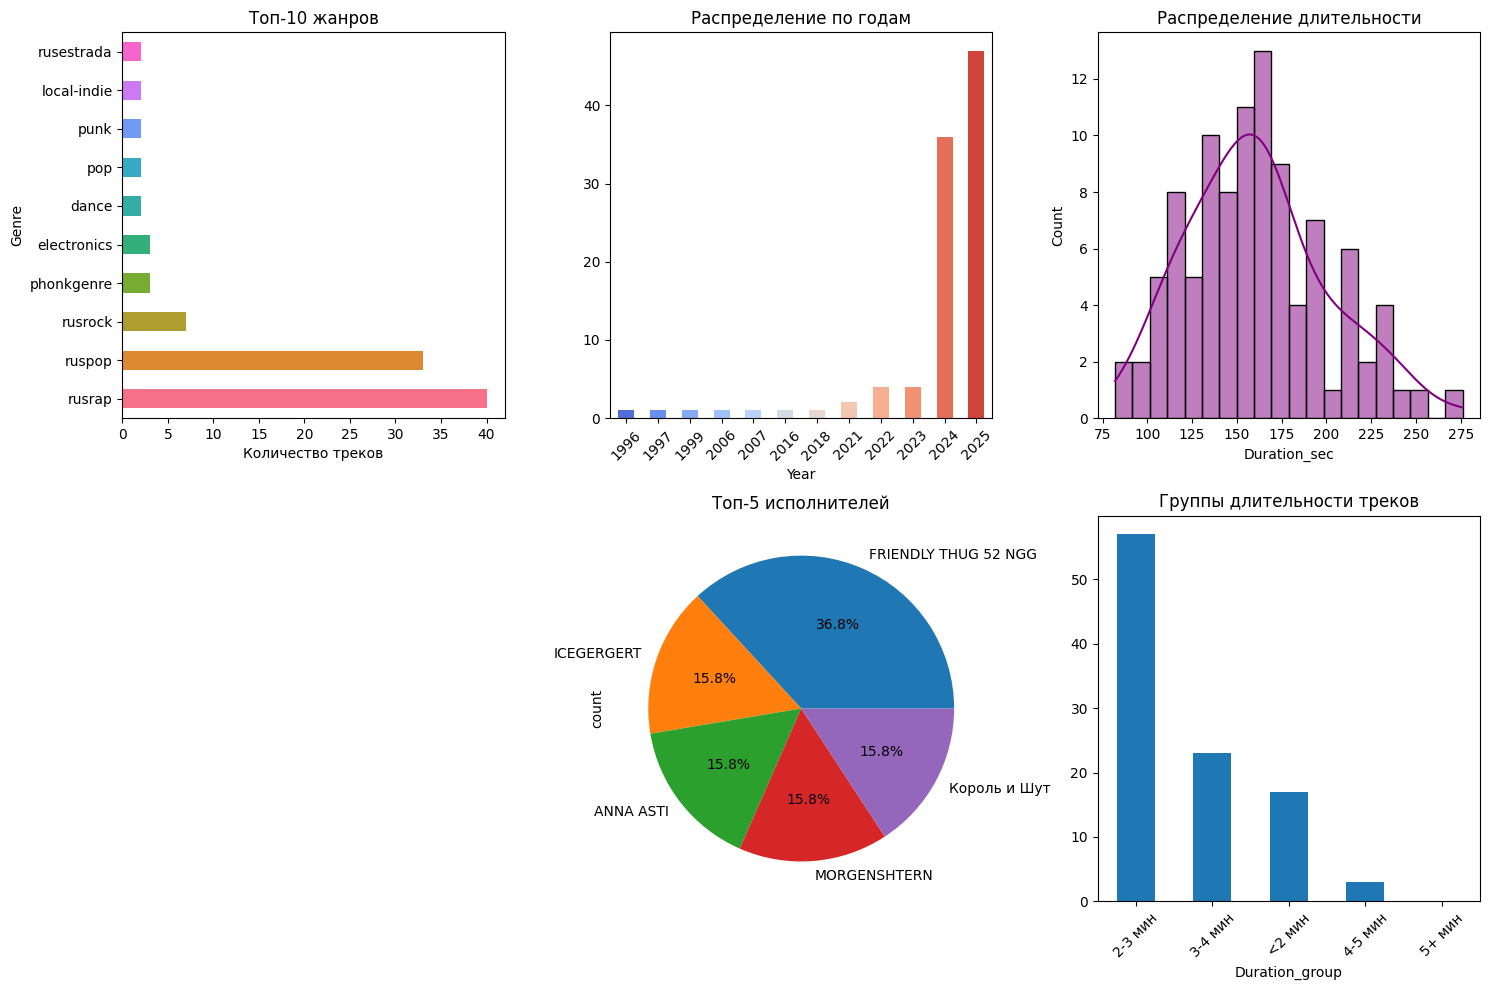


Очищенные данные сохранены в chart_clean.csv


In [12]:
# Чистка и анализ данных
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

def clean_and_prepare_data(df):
    """Очистка и подготовка данных"""
    # Преобразование длительности в секунды
    df['Duration_sec'] = df['Duration'].apply(
        lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]) 
        if isinstance(x, str) and ':' in x else None
    )
    
    # Очистка года
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    
    # Группировка длительности
    df['Duration_group'] = pd.cut(
        df['Duration_sec'],
        bins=[0, 120, 180, 240, 300, np.inf],
        labels=['<2 мин', '2-3 мин', '3-4 мин', '4-5 мин', '5+ мин']
    )
    
    return df

def exploratory_data_analysis(df):
    """Разведочный анализ данных (EDA)"""
    print("\n=== Разведочный анализ данных (EDA) ===")
    
    # 1. Описание типов переменных
    print("\n1. Типы переменных:")
    print(df.dtypes)
    
    # 2. Описательные статистики
    print("\n2. Описательные статистики числовых полей:")
    print(df.describe(include='number'))
    
    print("\nОписательные статистики категориальных полей:")
    print(df.describe(include='object'))
    
    # 3. Расширенный анализ уникальных значений
    print("\n3. Подробный анализ уникальных значений:")
    
    # Для категориальных колонок
    categorical_cols = df.select_dtypes(include=['object']).columns
    print("\nКатегориальные поля:")
    for col in categorical_cols:
        unique_count = df[col].nunique()
        print(f"\nКолонка '{col}':")
        print(f"- Уникальных значений: {unique_count}")
        print(f"- Примеры: {list(df[col].unique()[:5])}") 
        print(f"- Топ-3 частых:\n{df[col].value_counts().head(3)}")
    
    # Для числовых колонок
    numeric_cols = df.select_dtypes(include=['number']).columns
    print("\nЧисловые поля:")
    for col in numeric_cols:
        print(f"{col}: {df[col].nunique()} уникальных значений")
        print(f"Диапазон: от {df[col].min()} до {df[col].max()}")

    print("\nПервые 5 записей после очистки:")
    display(df.head())
    
    # 4. Визуализация
    print("\n4. Визуализация данных")
    
    plt.figure(figsize=(15, 10))
    
    # Топ-10 жанров
    plt.subplot(2, 3, 1)
    genre_counts = df['Genre'].value_counts().head(10)
    genre_counts.plot(kind='barh', color=sns.color_palette("husl", 10))
    plt.title('Топ-10 жанров')
    plt.xlabel('Количество треков')
    
    # Распределение по годам
    plt.subplot(2, 3, 2)
    year_counts = df['Year'].value_counts().sort_index()
    year_counts.plot(kind='bar', color=sns.color_palette("coolwarm", len(year_counts)))
    plt.title('Распределение по годам')
    plt.xticks(rotation=45)
    
    # Длительность треков
    plt.subplot(2, 3, 3)
    sns.histplot(df['Duration_sec'], bins=20, kde=True, color='purple')
    plt.title('Распределение длительности')
    
    # Топ исполнители
    plt.subplot(2, 3, 5)
    df['Artists'].value_counts().head(5).plot(kind='pie', autopct='%1.1f%%')
    plt.title('Топ-5 исполнителей')
    
    # Группы длительности
    plt.subplot(2, 3, 6)
    df['Duration_group'].value_counts().plot(kind='bar')
    plt.title('Группы длительности треков')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('yandex_chart_detailed_eda.png', dpi=300)
    print("\nГрафики сохранены в yandex_chart_detailed_eda.png")
    plt.show()

def save_clean_data(df):
    """Сохранение очищенных данных"""
    filename = f"chart_clean.csv"
    df.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"\nОчищенные данные сохранены в {filename}")

if __name__ == "__main__":
    # Загрузка данных
    try:
        df = pd.read_csv('chart.csv')
        print("Данные успешно загружены")
    except Exception as e:
        print(f"Ошибка загрузки данных: {e}")
        exit()
    
    # Очистка и подготовка
    print("\nОчистка и подготовка данных...")
    df_clean = clean_and_prepare_data(df)
    
    # Анализ
    print("\nВыполнение анализа...")
    exploratory_data_analysis(df_clean)
    
    # Сохранение
    save_clean_data(df_clean)